# Make Hazard Curves and Maps

This notebook illustrates how to make hazard curves and hazard maps by combining results from several events.

You should first go through these notebooks, which explain the main ideas:

- [Hazard_Maps.ipynb](Hazard_Maps.ipynb)
- [Hazard_Curves.ipynb](Hazard_Curves.ipynb)


### First set up some things needed in notebook....

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from __future__ import print_function  # for Python 3 compatibility
import sys, os
from ipywidgets import widgets
from IPython.display import Image, display

In [18]:
#from ipywidgets import interact      # for interactive widgets
from interact import interact        # for static figure that can be viewed online

Will create static figures with single value of parameters


### Read in the topography data:

In [19]:
# Read in topography data:

fixed_grid_file = os.path.join('MapsTopo', 'fixedgrid_xyB_small.npy')
d=load(fixed_grid_file)
x=d[:,0]
y=d[:,1]
B=d[:,2]
topo = reshape(B, (250,250), order='F')
X = reshape(x, (250,250), order='F')
Y = reshape(y, (250,250), order='F')

def plot_topo():
    fig = figure(figsize=(6,6))
    ax = axes()
    topo_clines = arange(0,20,2)
    contour(X,Y,topo,topo_clines,colors='k')
    CClatitude = 41.75  # to rescale longitude
    ax.set_aspect(1. / cos(pi*CClatitude/180.)) 
    ax.ticklabel_format(format='plain',useOffset=False)
    return fig


### Read in image of Crescent City as background for plots

In [20]:
CCmap = imread('MapsTopo/CCimage.png')
extent = (235.79781, 235.82087, 41.739671,41.762726)   #small region

### Show this image and contours of topography

This shows the region of Crescent City, CA that will be used for this example:

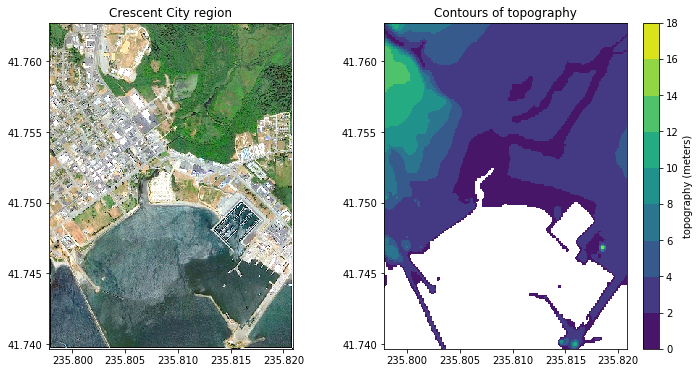

In [21]:
fig = figure(figsize=(12,6))
ax = subplot(1,2,1)
imshow(CCmap,extent=extent)
topo_clines = arange(0,20,2)

CClatitude = 41.75  # to rescale longitude
ax.set_aspect(1. / cos(pi*CClatitude/180.)) 
ax.ticklabel_format(format='plain',useOffset=False)
axis(extent);
title('Crescent City region')

ax = subplot(1,2,2)
topo_clines = arange(0,20,2)
contourf(X,Y,topo,topo_clines)
colorbar(label="topography (meters)")
CClatitude = 41.75  # to rescale longitude
ax.set_aspect(1. / cos(pi*CClatitude/180.)) 
ax.ticklabel_format(format='plain',useOffset=False)
axis(extent);
title('Contours of topography');

### Set the exceedance values

This should be a list or array of values $\zeta$ (`zeta`) representing depth of flooding on shore, or elevation above sea level offshore (in meters).  The hazard curves will be computed by determining the annual probability that the maximum $\zeta$ observed at each spatial point is above $\zeta_k$, for each value $\zeta_k$ in this list.

In [22]:
zeta = linspace(0,12,121)
nzeta = len(zeta)
print('%i exceedance values, \nzeta =  %s' % (nzeta,zeta))

121 exceedance values, 
zeta =  [  0.    0.1   0.2   0.3   0.4   0.5   0.6   0.7   0.8   0.9   1.    1.1
   1.2   1.3   1.4   1.5   1.6   1.7   1.8   1.9   2.    2.1   2.2   2.3
   2.4   2.5   2.6   2.7   2.8   2.9   3.    3.1   3.2   3.3   3.4   3.5
   3.6   3.7   3.8   3.9   4.    4.1   4.2   4.3   4.4   4.5   4.6   4.7
   4.8   4.9   5.    5.1   5.2   5.3   5.4   5.5   5.6   5.7   5.8   5.9
   6.    6.1   6.2   6.3   6.4   6.5   6.6   6.7   6.8   6.9   7.    7.1
   7.2   7.3   7.4   7.5   7.6   7.7   7.8   7.9   8.    8.1   8.2   8.3
   8.4   8.5   8.6   8.7   8.8   8.9   9.    9.1   9.2   9.3   9.4   9.5
   9.6   9.7   9.8   9.9  10.   10.1  10.2  10.3  10.4  10.5  10.6  10.7
  10.8  10.9  11.   11.1  11.2  11.3  11.4  11.5  11.6  11.7  11.8  11.9
  12. ]


### Set the desired annual rate for each event

In the next cell, `event_rate` is a Python dictionary. It is initialized to an empty dictionary and then we set `event_rate[key] = value` where the keys are the names of the hypothetical events and the associated value is the rate $\lambda$.  The return period is $1/\lambda$ and the corresponding annual proability of at least one such event is $p = 1 - \exp(-\lambda) \approx \lambda$.

Note that this catalog contains 6 possible Cascadia Subduction Zone (CSZ) events, with the assumption that the rate is $1/500$ for any major CSZ event (return period 500 years) and that there are 6 possibilities for such an event with conditional probabilities $0.0125, \ldots, 0.225$ that sum to 1. 

For this tutorial we are using only 14 events from a study that included 17 possible CSZ events and 15 other possible events, and for illustration purposes the probabilities have been adjusted.   For the original report see:

- *Probabilistic Tsunami Hazard Assessment (PTHA) for Crescent City, CA.*, by Frank I. Gonzalez, Randall J. LeVeque, Loyce M. Adams, Chris Goldfinger, George R. Priest, and Kelin Wang, <http://hdl.handle.net/1773/25916>


In [32]:
all_events = ['AASZa', 'AASZb', 'AASZc', 'AASZd', 'CSZa', 'CSZb', 'CSZc', 'CSZd', 'CSZe', \
              'CSZf', 'KmSZa', 'KrSZa', 'SChSZa', 'TOHa']

event_rate = {}
event_rate['AASZa'] = 1./394.
event_rate['AASZb'] = 1./750.
event_rate['AASZc'] = 1./563.
event_rate['AASZd'] = 1./324.
event_rate['CSZa'] = 1./500. * .0125
event_rate['CSZb'] = 1./500. * .0125
event_rate['CSZc'] = 1./500. * .0750
event_rate['CSZd'] = 1./500. * .5000
event_rate['CSZe'] = 1./500. * .1750
event_rate['CSZf'] = 1./500. * .2250
event_rate['KmSZa'] = 1./50.
event_rate['KrSZa'] = 1./167.
event_rate['SChSZa'] = 1./300.
event_rate['TOHa'] = 1./103.

print("Annual rate and probability for each event:")
for event in event_rate.iterkeys():
    lam = event_rate[event]
    p = 1 - exp(-lam)
    Rp = 1./lam
    print("event %6s:  return period = %5.0f years,  rate = %9.6f,  annual probability = %9.6f" \
          % (event, Rp, lam, p))

Annual rate and probability for each event:
event  AASZb:  return period =   750 years,  rate =  0.001333,  annual probability =  0.001332
event  AASZc:  return period =   563 years,  rate =  0.001776,  annual probability =  0.001775
event  AASZa:  return period =   394 years,  rate =  0.002538,  annual probability =  0.002535
event SChSZa:  return period =   300 years,  rate =  0.003333,  annual probability =  0.003328
event  AASZd:  return period =   324 years,  rate =  0.003086,  annual probability =  0.003082
event  KrSZa:  return period =   167 years,  rate =  0.005988,  annual probability =  0.005970
event   TOHa:  return period =   103 years,  rate =  0.009709,  annual probability =  0.009662
event  KmSZa:  return period =    50 years,  rate =  0.020000,  annual probability =  0.019801
event   CSZa:  return period = 40000 years,  rate =  0.000025,  annual probability =  0.000025
event   CSZb:  return period = 40000 years,  rate =  0.000025,  annual probability =  0.000025
event 

### Specify the set of events to include in computing hazard curves:

In [24]:
events = all_events

# Instead, to use a subset of the events, specify a list such as:
#events = ['AASZa', 'AASZb', 'AASZc']

### Compute the combined probability of exceeding each exceedance value:

We use results that were computed by running the [GeoClaw](http://www.geoclaw.org) tsunami modeling code with each of the events above.  These have been pre-computed and stored in the `Events` subdirectory, each one is read in to determine the `hmax` array for each event, which is the maximum inundation depth at each point on a grid coverting Crescent City as computed over the full tsunami simulation.

`exceed_prob` is computed as an array of shape `(nx,ny,nzeta)` where `(nx,ny)` is the shape of the grid covering Crescent City and `nzeta` is the number of exceedance values `zeta`.  After executing the cell below, `exceed_prob[i,j,k]` contains the annual probability of exceeding depth `zeta[k]` at grid point `(i,j)`.

We first compute `exceed_rate` by summing the exceedance rates $\lambda_e = $ `event_rate[e]` over all events `e` that exceeded this depth.

In [25]:
nx, ny = X.shape  # note that X is a 2d array of longitude values at each point
exceed_rate = zeros((nx,ny,nzeta))  # initialize to zero

# loop over all events and update exceed_rate at each grid point by combining
# current value with the rate of this event:

for event in events:
    
    # Load the precomputed hmax from this event over Crescent City:
    hmax_file = os.path.join('Events', event, 'h_eta_small.npy')
    hmax = load(hmax_file)
    Hmax = hmax.reshape((nx,ny),order='F')
    
    # Update the rate for each exceedance value that was exceeded by this event:
    for k in range(nzeta):
        lambda_k = exceed_rate[:,:,k]  # rates at all points for one exceedance value zeta_k
        exceed_rate[:,:,k] = where(Hmax > zeta[k], event_rate[event]+lambda_k, lambda_k)

# compute the probabilities from the rates:
exceed_prob = 1 - exp(-exceed_rate)

print("Computed exceedance probabilities on grid of size nx=%s by ny=%s for nzeta=%s exceedance values." \
      % (nx,ny,nzeta)) 

Computed exceedance probabilities on grid of size nx=250 by ny=250 for nzeta=121 exceedance values.


### Plot hazard curves

The array `exceed_prob[i,j,:]` (i.e. fixing i,j and letting the last index k vary from 0 to `nzeta - 1`) gives the probability of exceedance at the `(i,j)` grid point as we vary the exceedance value `zeta[k]`.  Plotting this gives exactly the hazard curve at the `(i,j)` point.

The function `plot_hcurve` defined below plots this for a given `(longitude, latitude)` by first figuring out the index `(i,j)` for the nearest point on the grid covering Crescent City.

In [26]:
dx = X[1,0] - X[0,0]
dy = Y[0,1] - Y[0,0]
nx, ny = X.shape
xmin = X.min(); xmax = X.max()
ymin = Y.min(); ymax = Y.max()

def plot_hcurve(longitude, latitude):
    i = int(round((longitude - X[0,0]) / dx))
    j = int(round((latitude - Y[0,0]) / dy))
    if (i<0) or (i>=nx) or (j<0) or (j>=ny):
        print("out of domain")
        return 
    fig = figure(figsize=(12,5))
    subplot(1,2,1)
    p = maximum(exceed_prob[i,j,:], 1e-10)
    semilogy(zeta, p, 'b')
    xlim(0,12)
    ylim(1e-5,1)
    xlabel('zeta in meters')
    ylabel('annual probability')
    title('Hazard Curve')
    
    # Also plot the CC image with a red dot showing the location:
    ax = subplot(1,2,2)
    imshow(CCmap,extent=extent)
    CClatitude = 41.75  # to rescale longitude
    ax.set_aspect(1. / cos(pi*CClatitude/180.)) 
    ax.ticklabel_format(format='plain',useOffset=False)
    plot([longitude], [latitude], 'ro')
    xlim(xmin,xmax)
    ylim(ymin,ymax)
    title('Location')
    show()


### Interactive viewer to plot the hazard curve

Use the slider bars to move the point around in Crescent City:

You must run the notebook in order to use the interactive widgets
Using initial widget values: {'latitude': 41.75, 'longitude': 235.805}


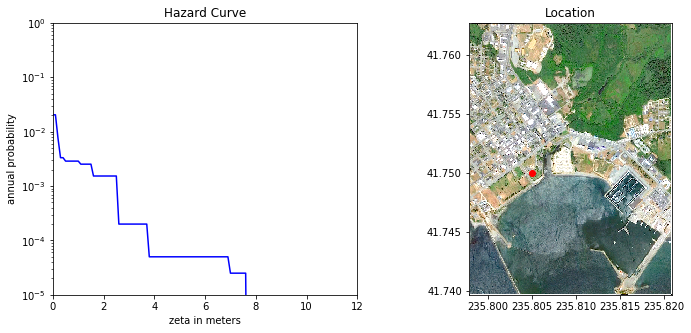

In [27]:
interact(plot_hcurve, longitude=widgets.FloatSlider(min=xmin,max=xmax,step=0.001,value=235.805,readout_format='.3f'),
         latitude=widgets.FloatSlider(min=ymin,max=ymax,step=0.001,value=41.75,readout_format='.3f'));

## Hazard Maps

If we fix `k` then `exceed_prob[:,:,k]` is a two dimensional array giving the probability of exceedance at all points on the grid for a fixed exceedance level `zeta[k]`.  We can plot this to obtain a hazard map showing probabilities for a given exceedance value.

### Define contours and colors and a function to plot probability maps

`prob_clines` will be the probability levels to use in contour maps

`prob_colors` will define the color map to use.   This is a list of tuples (R,G,B) of red,green,blue values, chosen to go from light blue to red.

**Note:** The function `plot_pmap` defined in the cell below uses the exceedance probabilities `exceed_prob` computed above.  If you recompute these (e.g. by changing the set of events to include, or the probabilities of individual events), you must re-execute this cell to redefine `plot_pmap` before re-making the plots in later cells!

In [28]:
prob_clines = [1e-5, 1e-4, 1e-3, 2e-3, 1e-2, 2e-2, 1e-1]
nlines = len(prob_clines)
n1 = int(floor((nlines-1)/2.))
n2 = nlines - 1 - n1

Green = hstack([linspace(1,1,n1),linspace(1,0,n2)])
Red = hstack([linspace(0,0.8,n1), ones(n2)])
Blue = hstack([linspace(1,0.2,n1), zeros(n2)])
prob_colors = zip(Red,Green,Blue)

color_offscale = (.5,0,0)  # color to use if above maximum
prob_colors.append(color_offscale)

    
def plot_pmap(k,background_map=True,topo_contours=False):
    
    fig = figure(figsize=(6,6))
    ax = axes()  
    
    if background_map:
        imshow(CCmap,extent=extent)
    if topo_contours:
        topo_clines = arange(0,20,2)
        contour(X,Y,topo,topo_clines,colors='k')

    CClatitude = 41.75  # to rescale longitude
    ax.set_aspect(1. / cos(pi*CClatitude/180.)) 
    ax.ticklabel_format(format='plain',useOffset=False)
    axis(extent)
    
    contourf(X,Y,exceed_prob[:,:,k], prob_clines, colors=prob_colors,alpha = 0.6, extend='max')
    title("Annual probability of flooding above %g meters" % zeta[k])
    colorbar(label="probability")
    show()    

### Interactive viewer of all hazard maps:

This interactive slider loops over `k`, the index into the array `zeta` of exceedance values.

You must run the notebook in order to use the interactive widgets
Using initial widget values: {'background_map': True, 'k': 20, 'topo_contours': False}


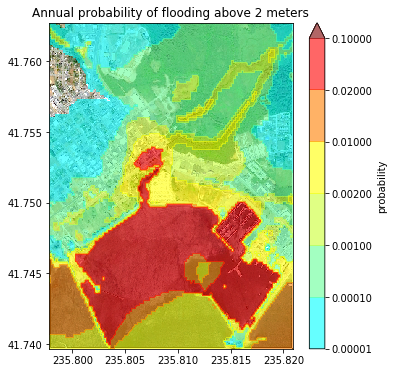

In [29]:
interact(plot_pmap, k=widgets.IntSlider(min=0, max=nzeta-1, step=1, value=20, readout=False),
        background_map=widgets.Checkbox(True),topo_contours=widgets.Checkbox(False))

### Inundation maps for given probability:

A more commonly used map is obtained by fixing a probability (e.g. $p = 0.01$ for a "100-year" flood map) and plotting the maximum depth expected with this annual probability.   

This requires determining, for each grid point `(i,j)`, the largest value of `k` for which `exceed_prob[k]`  $\geq p$. Then the value `zeta[k]` is the largest exceedance value for which the probability is at least $p$.

Recall that `zeta` is defined to be maximum depth of inundation on shore, or maximum height above MHW offshore.

**Note:** The functions `compute_zeta` and `plot_inundation_map` defined in the cell below uses the exceedance probabilities `exceed_prob` computed above.  If you recompute these (e.g. by changing the set of events to include, or the probabilities of individual events), you must re-execute this cell to redefine the functions before re-making the plots in later cells!

In [30]:
def compute_zeta(p):

    # create boolean array K with K[i,j,k] == True only where exceed_prob[i,j,k] > p:
    K = exceed_prob > p

    K[:,:,0] = True
    zeta_p = zeros(X.shape)
    for i in range(nx):
        for j in range(ny):
            zeta_p[i,j] = zeta[K[i,j,:]][-1]
    return zeta_p

# Set contour lines and colors for plotting zeta = inundation depth 

zeta_clines = [1e-3] + list(linspace(0.5,4.5,9))
nlines = len(zeta_clines)
n1 = int(floor((nlines-1)/2.))
n2 = nlines - 1 - n1
Green = hstack([linspace(1,1,n1),linspace(1,0,n2)])
Red = hstack([linspace(0,0.8,n1), ones(n2)])
Blue = hstack([linspace(1,0.2,n1), zeros(n2)])
zeta_colors = zip(Red,Green,Blue)
color_offscale = (.5,0,0)  # color to use if above maximum
zeta_colors.append(color_offscale)


def plot_inundation_map(p,background_map=True,topo_contours=False):
    
    fig = figure(figsize=(6,6))
    ax = axes()  
   
    if background_map:
        imshow(CCmap,extent=extent)
    if topo_contours:
        topo_clines = arange(0,20,2)
        contour(X,Y,topo,topo_clines,colors='k')

    CClatitude = 41.75  # to rescale longitude
    ax.set_aspect(1. / cos(pi*CClatitude/180.)) 
    ax.ticklabel_format(format='plain',useOffset=False)
    axis(extent)
    
    zeta_p = compute_zeta(p)
    contourf(X,Y,zeta_p,zeta_clines, colors=zeta_colors, alpha = 0.6, extend='max')
    title("Depth of flooding for annual probability %g\nReturn time %5.0f years" % (p, (1./p)))
    colorbar(label="depth (meters)")
    show()

### Interactive viewer for hazard maps with fixed probability

In this case the slider adjusts the probability and the map shows the expected depth of inundation with this annual probability.

You must run the notebook in order to use the interactive widgets
Using initial widget values: {'p': 0.001}


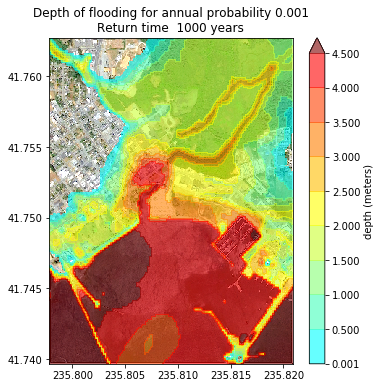

In [31]:
interact(plot_inundation_map, p=widgets.FloatSlider(min=0.00025, max=0.01, step=0.00025, 
                                                    value=0.001, readout_format='.5f'));